# 4. Computer Vision and Convolutional Neural Networks in TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognising the car in front.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

tf.__version__

'2.9.1'

## Architecture of a CNN

|Hyperparameter|What does it do?|Typical Values|
|--------------|----------------|--------------|
|Input Image(s)|Target images you'd like to discover patterns in|Whatever you can take a photo (or video) of|
|Input layer|Takes in target images and preprocesses them for further layers|input_shape = [batch_size, image_height, image_width, color_channels]|
|Convolutional layer|Extracts/learns the most important features from target images|Multiple, can create with `tf.keras.layers.ConvXD` (X can be multiple values)|
|Hidden activation|Adds non-linearity to the learned features (non-straight lines)|Usually ReLU (`tf.keras.activations.relu`)|
|Pooling layer|Reduces the dimensionality of learned image features|Average (`tf.keras.layers.AvgPool2D`) or Max (`tf.keras.layers.MaxPool2D`)|
|Fully connected layer|Further refines learned features from convolutional layers|`tf.keras.layers.Dense`|
|Output layer|Takes learned features and outputs them in shape of target labels|output_shape = [number_of_classes] (eg. 3 for pizza, steak or sushi)|
|Output activation|Adds non-linearities to output layer|`tf.keras.activations.sigmoid` (binary classification) or `tf.keras.activations.softmax` (multi-class classification)|

#### Specimen code

```
# 1. Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
cnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 10,
                               kernel_size = 3 # can also be (3,3)
                               activation = "relu",
                               input_shape = (224,224,3) # specify input shape (height, width, color channels)
                               ),
        tf.keras.layers.Conv2D(10, 3, activation = "relu"),
        tf.keras.layers.MaxPool2D(
                                 pool_size = 2, # can also be (2,2)
                                 padding = "valid" # can also be "same"
                                 ),
        tf.keras.layers.Conv2D(10, 3, activation = "relu"),
        tf.keras.layers.Conv2D(10, 3, activation = "relu"),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten()
        tf.keras.layers.Dense(1, activation = "sigmoid") # binary activation output
    ]
)

# 2. Compile the model
cnn_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 3. Fit the model
history = cnn_model.fit(train_dta, epochs = 5)
```

## Get the Data

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However, we've modified it to only use two classes (pizza and steak) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

> **Note:** We start with a smaller dataset so we can experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [2]:
import os
import zipfile

if os.path.exists('Data/Classification/pizza_steak.zip') == False:
    !curl https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip --output Data/Classification/pizza_steak.zip

zip = zipfile.ZipFile('Data/Classification/pizza_steak.zip')
zip.extractall('Data/Classification')
zip.close()

In [3]:
for dirpath, dirnames, filenames in os.walk('Data/Classification/pizza_steak'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} in "{dirpath}"')

There are 2 directories and 0 in "Data/Classification/pizza_steak"
There are 2 directories and 0 in "Data/Classification/pizza_steak\test"
There are 0 directories and 250 in "Data/Classification/pizza_steak\test\pizza"
There are 0 directories and 250 in "Data/Classification/pizza_steak\test\steak"
There are 2 directories and 0 in "Data/Classification/pizza_steak\train"
There are 0 directories and 750 in "Data/Classification/pizza_steak\train\pizza"
There are 0 directories and 750 in "Data/Classification/pizza_steak\train\steak"


In [4]:
num_steak_images_train = len(os.listdir('Data/Classification/pizza_steak/train/steak'))
num_steak_images_train

750

Get the class-names programmatically:

In [5]:
# Method 1
class_names = os.listdir('Data/Classification/pizza_steak/train')

# Method 2
import pathlib
data_dir = pathlib.Path('Data/Classification/pizza_steak/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names = class_names.astype('str')

## Viewing the data

In [6]:
import matplotlib.image as mpimg

def view_random_images(target_dir, target_class, num_images, image_matrix, figsize = (10,10)):
    """
    """
    images_chosen = np.random.choice(os.listdir(f'{target_dir}/{target_class}'), size = num_images)
    plt.figure(figsize = figsize)
    image_list = []
    for plot_idx in range(num_images):
        ax = plt.subplot(image_matrix[0], image_matrix[1], plot_idx+1)
        img = mpimg.imread(target_dir + "/" + target_class + "/" + images_chosen[plot_idx])
        plt.imshow(img);
        image_list.append(img)
        plt.title(f'{images_chosen[plot_idx]} -> {target_class.upper()}')
        plt.axis(False)
        print(f'Image Shape: {img.shape}') # show the shape of the image
    
    return image_list

Image Shape: (384, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)


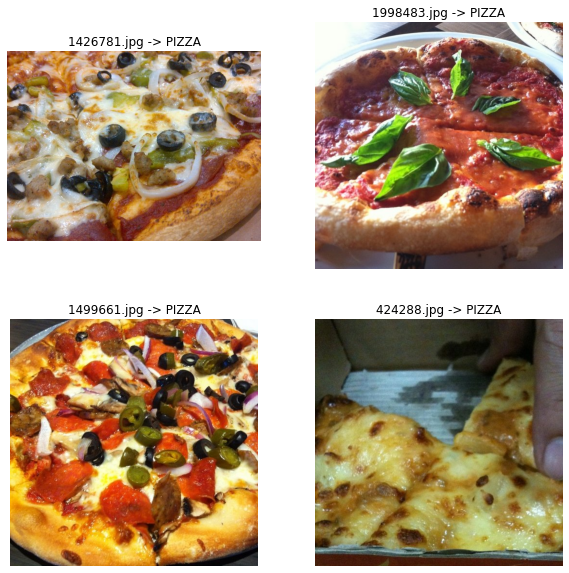

In [7]:
images = view_random_images('Data/Classification/pizza_steak/train', 'pizza', 4, (2,2))

**Note**: As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255 (since 255 is the maximum pixel value)

## An end-to-end example

Lets build a convolutional neural network to find patterns in our images. More specifically we need a way to:
* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess the data (get all the pixel values between 0 and 1 also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Setup paths to our data directories
train_dir = 'Data/Classification/pizza_steak/train'
test_dir = 'Data/Classification/pizza_steak/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                             batch_size = 32,
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             seed = 42
                                             )

test_dir = valid_datagen.flow_from_directory(test_dir,
                                             batch_size = 32,
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             seed = 42
                                             )

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)

model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = "relu", input_shape = (224,224,3), name = "input_layer"),
        tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = "relu", name = "conv_layer_1"),
        tf.keras.layers.MaxPool2D(pool_size=2, padding = "valid", name = "max_pool_layer_1"),
        tf.keras.layers.Conv2D(10, 3, activation = "relu", name = "conv_layer_2"),
        tf.keras.layers.Conv2D(10, 3, activation = "relu", name = "conv_layer_3"),
        tf.keras.layers.MaxPool2D(2, padding = "valid", name = "max_pool_layer_2"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ]
)

# Compile our CNN
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    metrics = ['accuracy']
)

# Fit the model
history_1 = model_1.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data)
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 28s 286ms/step - loss: 0.5818 - accuracy: 0.6900
Epoch 2/5
47/47 [==============================] - 6s 122ms/step - loss: 0.4259 - accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 6s 124ms/step - loss: 0.3918 - accuracy: 0.8367
Epoch 4/5
47/47 [==============================] - 5s 100ms/step - loss: 0.3479 - accuracy: 0.8580
Epoch 5/5
47/47 [==============================] - 5s 101ms/step - loss: 0.3193 - accuracy: 0.8693
